# Machine Learning for Signal Processing
### (ENGR-E 511)
### Homework 5

## Problem 1:  Kernel PCA

### Initializing the required libraries

In [1]:
# Importing all Required Libraries
import os
import numpy as np
import librosa as lb
import scipy.io
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
# Reading Data
shr_data = scipy.io.loadmat('E:/JupiterNotebook/data_hw_5/concentric.mat')

In [3]:
print(shr_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X'])


In [4]:
A = shr_data['X']

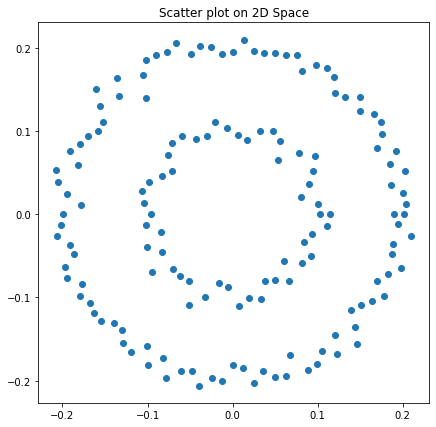

In [5]:
# Plotting Points in 2D space
plt.figure(figsize= (7,7))
plt.title('Scatter plot on 2D Space')
plt.scatter(A[0,:], A[1,:],)
plt.show()

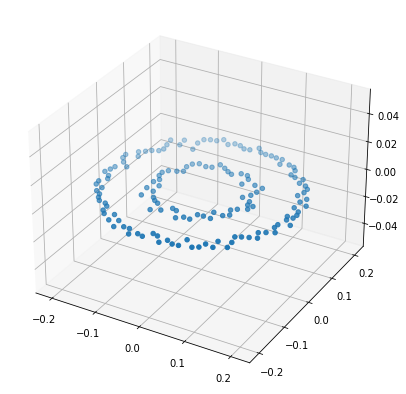

In [6]:
# Plotting Points in 3D space
fig3D = plt.figure(figsize= (7,7))
shr = fig3D.add_subplot(111, projection = '3d')
shr.scatter(A[0,:], A[1,:], c = None)
plt.show()

In [7]:
# Assigning random seed
np.random.seed(143)

In [8]:
# function to Calculating Eigen Decomposation 
def calc_eigen_decomp(X, num_eigen_vectors):
    itr = 0
    eigen_value = []
    eigen_vector = []
    
    for i in range(num_eigen_vectors):
        w = np.random.rand(X.shape[0], 1)
        
        for itr in range(1000):
            w = np.dot(X, w)
            w = w * (1/np.power(np.sum(np.power(w,2)),0.5))
            
        s1 = np.power(np.sum(np.power(np.dot(w.T, X), 2)), 0.5)
        u1 = np.dot(X.T, w) * (1/s1)
        contrib = s1 * np.dot(w, u1.T)
        
        # Substracting Contribution
        X = X - contrib
        
        eigen_value.append(s1)
        eigen_vector.append(w.reshape(-1,))

    eigen_vector = np.array(eigen_vector)

    return eigen_vector, eigen_value

In [9]:
# Calculating RBF Kernel
# Ref: https://en.wikipedia.org/wiki/Radial_basis_function_kernel
kernel = np.array([[np.exp(-np.sum((A[:,i] - A[:,j])**2/0.01)) for i in range(A.shape[1])] for j in range(A.shape[1])])
eigen_vec, eigen_val = calc_eigen_decomp(kernel, 3)

In [10]:
X = np.concatenate((eigen_vec, np.ones(eigen_vec.shape[1]).reshape(1,-1)), axis=0)
Y = np.array([int(i > 50) for i in range(152)])
#print(X)

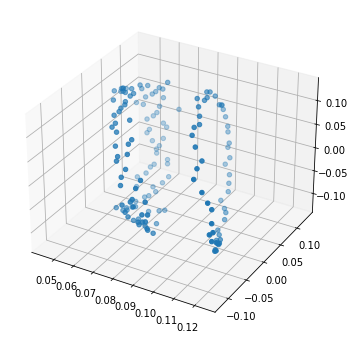

In [11]:
fig3D = plt.figure(figsize= (6,6))
shr = fig3D.add_subplot(111, projection = '3d')
shr.scatter(X[0,:], X[1,:], X[2,:], c = None)
plt.show()

In [12]:
def logistic(x):
    return 1/(1 + np.exp(-x))

In [13]:
W = np.random.uniform(0, 1, size=4).reshape(-1, 1)
err = []
max_itr = 100000
i = 0
a = 0.05

while i < max_itr:
    pred = logistic(np.dot(W.T, X))
    calc_error = 0.5 * (np.dot((Y - pred),(Y - pred).T))**2
    err.append(calc_error)

    delta_W = np.dot(X,((pred - Y) * pred * (1 - pred)).T)
    W = W - a * delta_W
    
    i += 1

In [14]:
calc_Y = logistic(np.dot(W.T, X))
E = 0.5 * (np.dot((Y-calc_Y),(Y-calc_Y).T))**2

In [15]:
print('Calculated Weights of the perceptron are: ' + str(W.flatten()))

Calculated Weights of the perceptron are: [-165.01589498  -21.7884929    -6.92618088   14.67700055]


In [16]:
print('Calculated Error is: ' + str(E[0][0]))

Calculated Error is: 0.22676779116977785


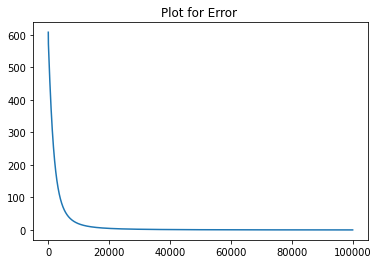

In [17]:
# Plotting Error plot
plt.title('Plot for Error ')
plt.plot(np.array(err).reshape(max_itr,1))
plt.show()

## Problem 2: Neural Networks

In [18]:
shr_data = A/np.sum(A, axis = 1).reshape(-1,1)

In [19]:
X = np.concatenate((shr_data, np.ones([1,shr_data.shape[1]])))
Y = np.array([int(i>50) for i in range(shr_data.shape[1])])

In [20]:
# Assigning random seed
np.random.seed(143)

In [21]:
def neural_net(X, Y, max_itr, alpha):
    
    W1 = np.random.randn(3,3)
    W2 = np.random.randn(1,4)

    err = []
    
    i = 0
    
    while i < max_itr:
        
        fl_out = logistic(np.dot(W1, X))
        fl_out = np.concatenate((fl_out, np.ones([1, fl_out.shape[1]])))
        
        pred = logistic(np.dot(W2, fl_out))
        
        bp_err_out = (pred - Y) * (pred * (1 - pred))
        delta_output = np.dot(bp_err_out, fl_out.T)
        W2 = W2 - alpha * delta_output
        
        bp_err_ft = np.dot(W2.T, bp_err_out) * (fl_out * (1 - fl_out))
        delta_ft = np.dot(bp_err_ft, X.T)[:3,:]
        
        W1 = W1 - alpha * delta_ft
        
        err.append(0.5 * np.dot((pred - Y), (pred - Y).T))
        
        i += 1
        
    return W1, W2, np.array(err).reshape(max_itr, 1)

In [22]:
W1, W2, err_plt = neural_net(X, Y, 10000, 0.08)

In [23]:
print("Calculated W1 is \n",W1)

Calculated W1 is 
 [[ 1.95422533  5.59795399 -3.91971024]
 [-6.94663157  3.9062971   3.69528418]
 [-7.919041   -1.25011707 -3.41068196]]


In [24]:
print("Calculated W2 is \n", W2)

Calculated W2 is 
 [[ 17.93562367 -17.84321256  18.52537274   4.70099269]]


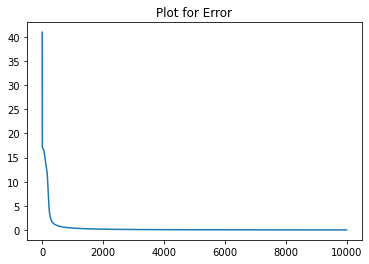

In [25]:
# Plotting error plot
plt.title('Plot for Error')
plt.plot(err_plt)
plt.show()

## Problem 3: Spoken MNIST

In [26]:
# Data from https://github.com/Jakobovski/free-spoken-digit-dataset
os.chdir('E:/JupiterNotebook/data_hw_5/free-spoken-digit-dataset-master/recordings')

In [27]:
#Cheking No of files
len(os.listdir())

3000

In [28]:
train_list = []
test_list = []
labels = []
predicted = []
score = {}

# reading only files containing Jackson
files = [f for f in os.listdir() if 'jackson' in os.path.splitext(f)[0]]

#Splitting files in Tain and Test files
for f in files:
    #print(f)
    fnew = f.split('_')
    if(int(fnew[2].split('.wav')[0])<45):
        train_list.append(f)
    else:
        test_list.append(f)

#Printing Lengths
print("Train Data Length is", len(train_list))
print("Test Data Length is", len(test_list))

Train Data Length is 450
Test Data Length is 50


In [29]:
# Function for Data Preparation 
def DataPrep(list):
    A = {}
    # Extracting Lables from the Filenames
    for f in list:
        #print(f)
        shr = f.split('.')[0].split('_')[0]
        data,sr = lb.load(f,sr=None)
        av = lb.feature.mfcc(y=data,sr=sr)
        

        if shr not in A.keys():
            A[shr] = []
            A[shr].append(av)
        else:
            feat = A[shr]
            feat.append(av)
            A[shr] = feat
    return A

In [30]:
# Preparing data 
train_data = DataPrep(train_list)
test_data = DataPrep(test_list)

In [31]:
print(len(train_data))
train_data.keys()

10


dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [32]:
print(len(test_data))
test_data.keys()

10


dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [33]:
# ref: https://hmmlearn.readthedocs.io/en/latest/api.html?highlight=gmmhmm#gmmhmm

def GMM_HMM(data):
    GMM_HMM_mod = []
    for i in range(10):
        mod = hmm.GMMHMM(n_components=1, covariance_type='full', n_iter=350, tol=0.000001)        
        Data = data[str(i)]
        mod.fit(np.hstack(Data).T) 
        GMM_HMM_mod.append(mod)
        
    return GMM_HMM_mod

In [34]:
models = GMM_HMM(train_data)
#models

In [35]:
for test_lb in test_data.keys():
    test_ft = test_data[str(test_lb)]
    
    for md_lb in range(len(models)):
        md = models[md_lb]
        scr = md.score(np.hstack(test_ft).T)
        score[md_lb] = scr
        
    pred = max(score, key=score.get)
    predicted.append(str(pred))
    labels.append(str(test_lb))
    
    print("\nTest on lb ", test_lb, ": predict  lb is ", pred)
    print("Scores received feature were : \n",score)


Test on lb  0 : predict  lb is  0
Scores received feature were : 
 {0: -4481.522177615516, 1: -7208.596580765812, 2: -7359.048913732456, 3: -7365.48387078718, 4: -8421.645509221844, 5: -8407.641447128219, 6: -7773.799542236801, 7: -9700.748505033982, 8: -8013.293561254594, 9: -7643.147329582322}

Test on lb  1 : predict  lb is  1
Scores received feature were : 
 {0: -5748.167971346306, 1: -3474.3128438560557, 2: -5698.822254916891, 3: -5833.589742171308, 4: -6186.429432422553, 5: -5773.980469247362, 6: -6270.460810175211, 7: -5784.268253776746, 8: -6078.888335121951, 9: -4619.055526845063}

Test on lb  2 : predict  lb is  2
Scores received feature were : 
 {0: -4724.773620361356, 1: -6476.7689563522035, 2: -3357.2154729748913, 3: -4512.591557868503, 4: -7649.315195484289, 5: -6929.220370003892, 6: -6332.534100701737, 7: -7081.086799209076, 8: -5114.978769860805, 9: -6949.738413057047}

Test on lb  3 : predict  lb is  3
Scores received feature were : 
 {0: -3969.5700914073905, 1: -6306

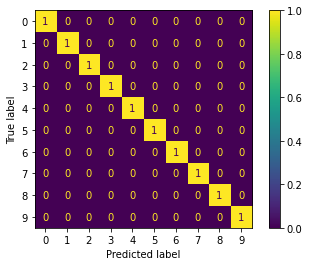

In [36]:
# Displaying Confusion Matrix
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
confused=ConfusionMatrixDisplay(confusion_matrix(labels,predicted),display_labels=test_data.keys())
confused.plot()
plt.show()